# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from xgboost import XGBClassifier, plot_importance

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Function


In [2]:
def balanced_recall_accuracy(y_true, y_pred, alpha=0.7):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return alpha * recall_class1 + (1 - alpha) * accuracy  # Weighted sum

In [3]:
def constrained_recall_scorer(y_true, y_pred):
    recall_0 = recall_score(y_true, y_pred, pos_label=0)  # Recall for Class 0
    accuracy = accuracy_score(y_true, y_pred)
    
    # Penalize if Class 0 recall < 0.6, else reward accuracy
    if recall_0 < 0.6:
        return -1  # Invalid solution (heavily penalized)
    else:
        return accuracy  # Or combine with Class 1 recall: (recall_0 + recall_score(y_true, y_pred, pos_label=1)) / 2

In [4]:

# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Accuracy: {accuracy_score(val_true, val_preds):.4f}')

# Model evaluation
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())

    return {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

In [5]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Let's modify the Investment Dataset class to handle both Pandas and PyTorch
class InvestmentDatasetFixed(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        # Check if y is already a tensor or needs to be converted
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to get predictions from the enhanced MLP model (i.e., the last estimated one)
def get_predictions_from_mlp(model, X_test):
    # Create a dataset and dataloader for predictions
    dummy_y = pd.Series(np.zeros(len(X_test)))  # Creating a Panda series
    test_dataset = InvestmentDatasetFixed(X_test, dummy_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get predictions
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())

    return np.array(all_preds)

# Import data

In [6]:
# 1. Définir la cible
target = 'AccumulationInvestment'

df_clients = pd.read_excel("df_accumulation.xlsx", sheet_name="ProcessedData")
df_products = pd.read_excel("Dataset2_Needs.xls", sheet_name="Products")

X = df_clients.drop(columns=[target])
y = df_clients[target]
X.head()

,Age,FinancialEducation,Income,Wealth
0,60,0.228685,68.181525,53.260067
1,78,0.358916,21.807595,135.550048
2,33,0.317515,23.252747,66.303678
3,69,0.767685,166.189034,404.997689
4,58,0.429719,21.186723,58.911930


In [7]:
df_clients_transformed = pd.read_excel("df_accumulation_preprocessed.xlsx", sheet_name="ProcessedData")
X_transformed = df_clients_transformed.drop(columns=[target])
y_transformed = df_clients_transformed[target]
X_transformed.head()

,Age,FinancialEducation,Income,Wealth
0,0.3125,-0.873326,0.253488,-0.193803
1,1.4375,-0.268517,-0.786332,0.681875
2,-1.3750,-0.460788,-0.736832,0.003208
3,0.8750,1.629849,1.345268,1.828994
4,0.1875,0.060300,-0.808293,-0.103730


In [8]:
# Initialize a completely empty DataFrame
nba = pd.DataFrame()

In [9]:
custom_scorer = make_scorer(constrained_recall_scorer)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42)

# Logistic Regression

In [12]:
best_params = {'C': 1, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}

# 3. Modèle
log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train, y_train)

# 4. Prédictions
y_pred_test = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X)[:, 1]  # probabilité sur l'ensemble

# 5. Rapport de classification
print(f"\n📊 Résultats pour : {target}")
print("-" * 40)
print(classification_report(y_test, y_pred_test))

# 6. Stockage des probabilités dans df_clients
nba[f'reg_log_{target}_proba'] = y_pred_proba


📊 Résultats pour : AccumulationInvestment
----------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       489
           1       0.71      0.57      0.63       511

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.67      0.66      0.66      1000



C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


# XGB


Training XGBoost for: AccumulationInvestment

Classification Report :
               precision    recall  f1-score   support

           0       0.79      0.70      0.74       489
           1       0.74      0.83      0.78       511

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000

ROC AUC Score : 0.8536


<Figure size 1000x600 with 0 Axes>

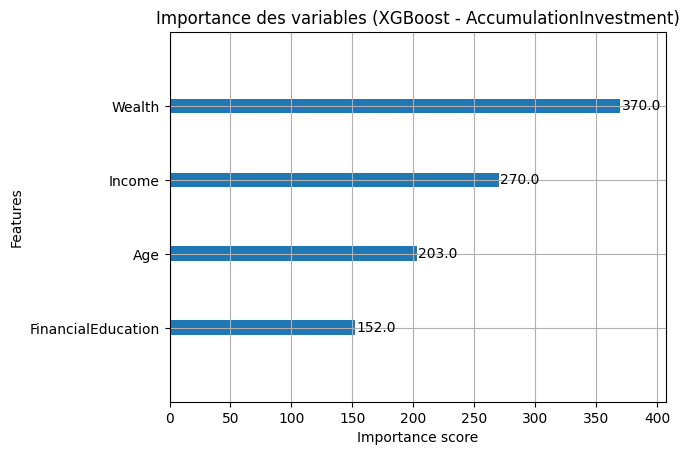

In [13]:
best_params = {'colsample_bytree': 1.0, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 90, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'subsample': 0.9}
print(f"\nTraining XGBoost for: {target}")
print("=" * 50)
  
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Évaluation
print("\nClassification Report :\n", classification_report(y_test, y_pred))
print(f"ROC AUC Score : {roc_auc_score(y_test, y_proba):.4f}")

# Affichage des features
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title(f"Importance des variables (XGBoost - {target})")
plt.show()


nba[f'xgb_proba_{target}'] = model.predict_proba(X)[:, 1]

# Random Forest

In [14]:
best_params = {
    'bootstrap': True,
    'class_weight': None,
    'max_depth': None,      # Unlimited tree depth
    'max_features': 0.8,    # 80% features per split
    'min_samples_leaf': 2,  # Min samples in leaf nodes
    'min_samples_split': 10,# Min samples to split node
    'n_estimators': 150     # 150 trees
}

# Initialize and train
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)  # Replace with your data

# Évaluation
y_pred_rf = model.predict(X_test)
y_proba_rf = model.predict_proba(X_test)[:, 1]

    
print("\nClassification Report :")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC : {roc_auc_score(y_test, y_proba_rf):.4f}")

# Ajout des prédictions optimisées au DataFrame
nba[f'rf_proba_{target}'] = model.predict_proba(X)[:, 1]


Classification Report :
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       489
           1       0.86      0.75      0.80       511

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000

ROC AUC : 0.8584


# Neural Network

In [15]:
print(f"\nTraining MLP for: {target}")
print("=" * 50)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Préparation des datasets
train_dataset = InvestmentDataset(X_train, y_train)
test_dataset = InvestmentDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialiser modèle, loss, optimizer
model = MLP(input_size=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement (tu peux remplacer par train_model_with_curves)
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

# Get metrics
train_metrics = evaluate_nn_metrics(model, train_loader)
test_metrics = evaluate_nn_metrics(model, test_loader)

# Display results
metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Test': test_metrics
}).round(3)

print("\nNeural Network Metrics:")
print(metrics_df)


Training MLP for: AccumulationInvestment
Epoch 10, Train Loss: 0.5487, Val Loss: 0.4930, Val Accuracy: 0.7730
Epoch 20, Train Loss: 0.5428, Val Loss: 0.4805, Val Accuracy: 0.7790
Epoch 30, Train Loss: 0.5338, Val Loss: 0.4832, Val Accuracy: 0.7730
Epoch 40, Train Loss: 0.5138, Val Loss: 0.4514, Val Accuracy: 0.7900
Epoch 50, Train Loss: 0.5248, Val Loss: 0.5020, Val Accuracy: 0.7530

Neural Network Metrics:
           Training   Test
accuracy      0.750  0.753
precision     0.857  0.853
recall        0.617  0.624
f1            0.717  0.721



Training Enhanced MLP for: AccumulationInvestment
Epoch 10, Train Loss: 0.5536, Val Loss: 0.5008, Val Accuracy: 0.7800
Epoch 20, Train Loss: 0.5389, Val Loss: 0.5120, Val Accuracy: 0.7470
Epoch 30, Train Loss: 0.5277, Val Loss: 0.4592, Val Accuracy: 0.7940
Epoch 40, Train Loss: 0.5316, Val Loss: 0.4832, Val Accuracy: 0.7660
Epoch 50, Train Loss: 0.5261, Val Loss: 0.4541, Val Accuracy: 0.7950
Epoch 60, Train Loss: 0.5261, Val Loss: 0.4901, Val Accuracy: 0.7560
Epoch 70, Train Loss: 0.5208, Val Loss: 0.4636, Val Accuracy: 0.7850
Epoch 80, Train Loss: 0.5184, Val Loss: 0.5039, Val Accuracy: 0.7510
Epoch 90, Train Loss: 0.5153, Val Loss: 0.4850, Val Accuracy: 0.7590
Epoch 100, Train Loss: 0.5160, Val Loss: 0.4686, Val Accuracy: 0.7820


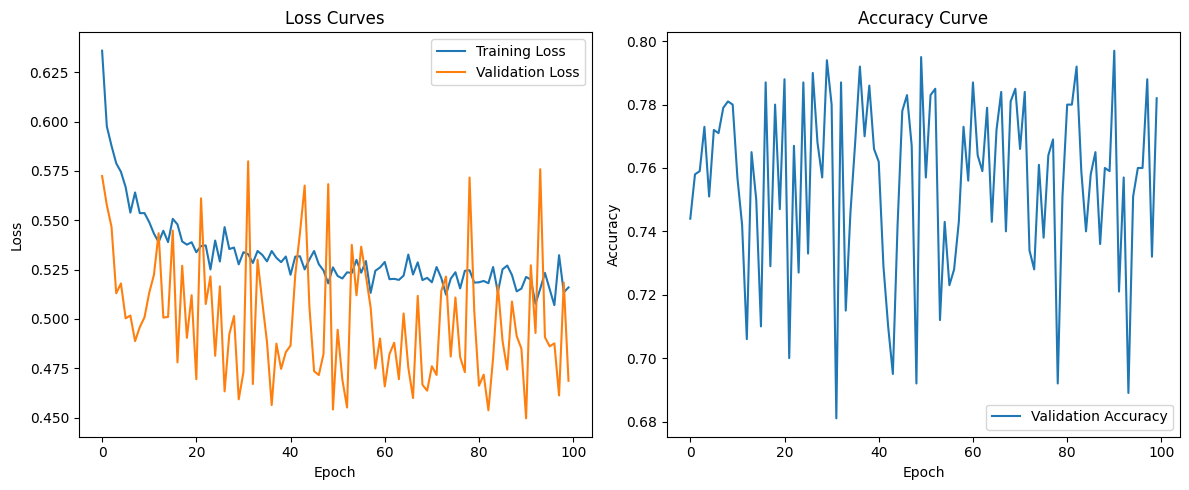


Results for AccumulationInvestment

Neural Network Metrics:
           Training   Test
accuracy      0.780  0.782
precision     0.875  0.871
recall        0.667  0.673
f1            0.757  0.759
Prédictions ajoutées : mlp_proba_AccumulationInvestment


In [16]:
print(f"\nTraining Enhanced MLP for: {target}")
print("=" * 60)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Datasets & Loaders avec InvestmentDatasetFixed
train_dataset = InvestmentDatasetFixed(X_train, y_train)
test_dataset = InvestmentDatasetFixed(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Modèle & optimiseur
model = MLP(input_size=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement avec courbes
model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

# Prédictions sur l’ensemble du dataset
dummy_y = pd.Series(np.zeros(len(X)))  # y fictif
full_dataset = InvestmentDatasetFixed(X, dummy_y)
full_loader = DataLoader(full_dataset, batch_size=32)

model.eval()
all_proba = []

with torch.no_grad():
    for X_batch, _ in full_loader:
        y_pred = model(X_batch).squeeze()
        all_proba.extend(y_pred.numpy())

all_proba = np.array(all_proba)
all_pred = (all_proba > 0.5).astype(int)
    
# Display final metrics
print(f"\nResults for {target}")
print("=" * 50)

train_metrics = evaluate_nn_metrics(model, train_loader)
test_metrics = evaluate_nn_metrics(model, test_loader)

metrics_df = pd.DataFrame({
    'Training': train_metrics,
    'Test': test_metrics
}).round(3)

print("\nNeural Network Metrics:")
print(metrics_df)

# Ajout dans df_clients
nba[f'mlp_proba_{target}'] = all_proba

print(f"Prédictions ajoutées : mlp_proba_{target}")

In [18]:

nba['Final_prediction_AccumulationInvestment'] = (
    nba[['reg_log_AccumulationInvestment_proba', 'xgb_proba_AccumulationInvestment', 
                'rf_proba_AccumulationInvestment', 'mlp_proba_AccumulationInvestment']]
    .mean(axis=1)
    .apply(lambda x: 1 if x >= 0.5 else 0)
)

nba.to_excel(
    "nba.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)